In [1]:
using LinearAlgebra, Statistics
using Distributions, Interpolations, LaTeXStrings, Parameters, Plots, Random

In [31]:
# model
function LucasTree(;γ = 2.0,
                    β = 0.95,
                    α = 0.9,
                    σ = 0.1,
                    grid_size = 100)

    ϕ = LogNormal(0.0, σ)
    shocks = rand(ϕ, 500)

    # build a grid with mass around stationary distribution
    ssd = σ / sqrt(1 - α^2)
    grid_min, grid_max = exp(-4ssd), exp(4ssd)
    grid = range(grid_min, grid_max, length = grid_size)

    # set h(y) = β * int u'(G(y,z)) G(y,z) ϕ(dz)
    h = similar(grid)
    for (i, y) in enumerate(grid)
        h[i] = β * mean((y^α .* shocks).^(1 - γ))
    end

    return (γ = γ, β = β, α = α, σ = σ, ϕ = ϕ, grid = grid, shocks = shocks, h = h)
end

# approximate Lucas operator, which returns the updated function Tf on the grid
function lucas_operator(lt, f)

    # unpack input
    (;grid, α, β, h) = lt
    z = lt.shocks

    Af = LinearInterpolation(grid, f, extrapolation_bc=Line())

    Tf = [ h[i] + β * mean(Af.(grid[i]^α .* z)) for i in 1:length(grid) ]
    return Tf
end

# get equilibrium price for Lucas tree
function solve_lucas_model(lt;
                           tol = 1e-6,
                           max_iter = 500)

    (;grid, γ) = lt

    i = 0
    f = zero(grid)  # Initial guess of f
    error = tol + 1

    while (error > tol) && (i < max_iter)
        f_new = lucas_operator(lt, f)
        error = maximum(abs, f_new - f)
        f = f_new
        i += 1
    end

    # p(y) = f(y) * y ^ γ
    price = f .* grid.^γ

    return price, f, grid
end

solve_lucas_model (generic function with 1 method)

In [32]:
Random.seed!(42) # For reproducible results.

tree = LucasTree(γ = 2.0, β = 0.95, α = 0.90, σ = 0.1)
price_vals, f_vals, grid_vals = solve_lucas_model(tree);

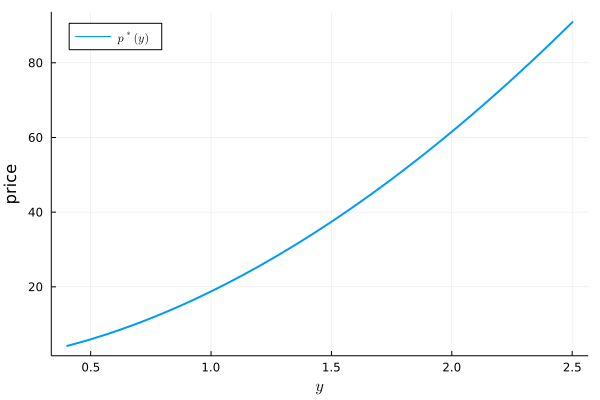

In [5]:
plot(tree.grid, price_vals, lw = 2, label = L"p^*(y)")
plot!(xlabel = L"y", ylabel = "price", legend = :topleft)

In [35]:
price_vals

100-element Vector{Float64}:
  4.130861017051104
  4.491903652946199
  4.86467160701915
  5.249454536197109
  5.6462379407374135
  6.054983096804136
  6.475623750206866
  6.908071411863407
  7.352239380828603
  7.808039476700189
  8.275392624665223
  8.75423291641603
  9.244498545134588
  ⋮
 76.71521705445866
 77.97380339739257
 79.2414089710367
 80.51799879915326
 81.80353696460774
 83.09798806460302
 84.4013022093763
 85.7134245635016
 87.03430902373792
 88.36390937369374
 89.7021522425057
 91.04898775582252

In [34]:
f_vals

100-element Vector{Float64}:
 25.888833452660315
 25.37917478827932
 24.905492109207437
 24.465896086730762
 24.057019184787677
 23.675785122709698
 23.31939142001529
 22.985315393373266
 22.671363826345498
 22.375612509669143
 22.096395607712775
 21.83227387473323
 21.58197623842804
  ⋮
 14.892273340008549
 14.85705923658295
 14.822304608805844
 14.787995564903357
 14.754118592772908
 14.720660806195935
 14.687607300293017
 14.654942979374491
 14.622654894129072
 14.590730619031476
 14.559153837718057
 14.527912771745289

In [30]:
Y = Array(tree.grid)
price_vals .* Y.^(-2.0).* Y.^(2.0)

100-element Vector{Float64}:
  4.130861017051104
  4.4919036529462
  4.86467160701915
  5.249454536197109
  5.646237940737414
  6.054983096804135
  6.475623750206865
  6.908071411863408
  7.352239380828602
  7.808039476700189
  8.275392624665223
  8.75423291641603
  9.244498545134588
  ⋮
 76.71521705445866
 77.97380339739259
 79.2414089710367
 80.51799879915326
 81.80353696460774
 83.097988064603
 84.4013022093763
 85.7134245635016
 87.0343090237379
 88.36390937369374
 89.7021522425057
 91.04898775582252

In [37]:
Array(grid_vals)

100-element Vector{Float64}:
 0.39945149497311855
 0.4207038320317295
 0.44195616909034047
 0.4632085061489514
 0.4844608432075624
 0.5057131802661733
 0.5269655173247842
 0.5482178543833952
 0.5694701914420062
 0.5907225285006171
 0.6119748655592281
 0.633227202617839
 0.65447953967645
 ⋮
 2.2696571561308825
 2.2909094931894938
 2.3121618302481046
 2.3334141673067155
 2.3546665043653263
 2.3759188414239376
 2.3971711784825485
 2.4184235155411593
 2.43967585259977
 2.4609281896583814
 2.4821805267169923
 2.503432863775603